In [79]:
!pip install yfinance
!pip install numpy_financial
!pip install tiingo
!pip install cnbcfinance  --upgrade

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


plt.style.use("seaborn")
import seaborn
import yfinance as yf
from tiingo import TiingoClient #pip install tiingo se manca il pacchetto su anaconda

capital=100000
config = {}
config['session'] = True
config['api_key'] = "fbb82277db40c7a1924d0a5bcf1d563bd21323cd"
client = TiingoClient(config)
capitale=100000#capitale iniziale



ticker=["SPY","IJR","TLT","LQQ.PA"]
df=yf.download(ticker ,start="2002-08-1",interval='1mo')["Adj Close"]

df

[*********************100%%**********************]  4 of 4 completed


,IJR,LQQ.PA,SPY,TLT
Date,,,,
2002-08-01,12.738648,NaN,61.020477,42.569702
2002-09-01,11.974949,NaN,54.378567,44.192741
2002-10-01,12.344835,NaN,59.116901,42.581043
2002-11-01,13.009408,NaN,62.763325,42.161663
2002-12-01,12.550900,NaN,58.923222,43.846668
...,...,...,...,...
2023-08-01,100.291687,740.500000,446.954895,94.848183
2023-09-01,93.872940,685.700012,424.257355,87.285500
2023-10-01,88.889999,639.000000,416.511292,82.503143


In [6]:

def calculate_bond_price(face_value, yield_rate, years_to_maturity, compounding_frequency=1):
    # Convert annual yield to decimal
    yield_decimal = yield_rate / 100.0

    # Calculate the number of compounding periods
    periods = years_to_maturity * compounding_frequency

    # Calculate the bond price
    price = face_value / (1 + yield_decimal / compounding_frequency)**periods

    return price

# Ticker for 30-year Treasury yield
tyx_ticker = "^TYX"

# Fetch historical data for the ^TYX yield
tyx_data = yf.download(tyx_ticker, start="1993-01-01", interval='1mo')

# Assuming a face value of 1000 for simplicity
face_value = 1000

# Create an empty DataFrame to store results
bond_prices = pd.DataFrame(index=tyx_data.index, columns=["Bond_Price"])

# Calculate bond prices for each date
for date, row in tyx_data.iterrows():
    bond_prices.loc[date, "Bond_Price"] = calculate_bond_price(face_value, row["Close"], 30)

# Print or use the resulting DataFrame
print(bond_prices)

[*********************100%%**********************]  1 of 1 completed
            Bond_Price
Date                  
1993-01-01  123.862863
1993-02-01  135.104194
1993-03-01  133.971684
1993-04-01  133.222125
1993-05-01  132.105893
...                ...
2023-08-01  290.715571
2023-09-01  251.322163
2023-10-01    229.9278
2023-11-01  266.005474
2023-12-01  305.222028

[372 rows x 1 columns]


In [7]:
#df=client.get_dataframe(["SPY","IJR","TLT"],frequency='monthly',metric_name='adjClose',startDate='2002-08-01')#scarico i dati
#df

In [27]:
df_az=df[["SPY","LQQ.PA"]].copy()#copio i dati azionari in un dataframe
df_ob=df["TLT"].copy()#copio i dati obbligazionari in un dataframe


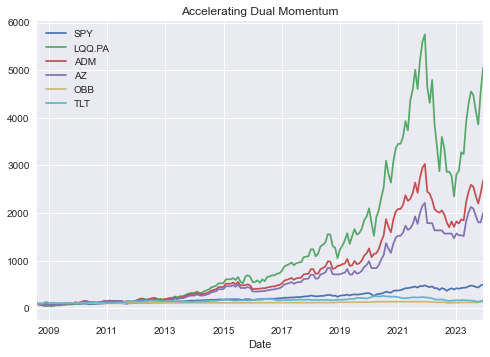

In [28]:
df_az_momentum=(df_az.pct_change()+df_az.pct_change(3)+df_az.pct_change(6)).shift().dropna()#calcolo il momentum a 1,3,6 mesi
df_az_rank=df_az_momentum.rank(axis=1,ascending=False).applymap(lambda x:0 if x>1 else 1)#faccio la classifica per vedere il più forte
df_azionario=(df_az_momentum>0).sum(axis=1).apply(lambda x:1 if x>=1 else 0)#applico il segnale all'azionario
df_obbligazionario=df_azionario.apply(lambda x:1 if x==0 else 0)#applico il segnale opposto all'obbligazionario
df_rendimento_az=((df_az_rank*df_az.pct_change()).sum(axis=1)*df_azionario)
df_rendimento_ob=(df_ob.pct_change()*df_obbligazionario).dropna()#sommo i rendimenti tra azionario e obbligazionario
df_az["ADM"]=((1+(df_rendimento_az+df_rendimento_ob)).cumprod()-1)*capitale+capitale#faccio la produttoria dei rendimenti sui soldi
df_az["AZ"]=((1+(df_rendimento_az)).cumprod()-1)*capitale+capitale
df_az["OBB"]=((1+(df_rendimento_ob)).cumprod()-1)*capitale+capitale
df_az["TLT"]=((1+(df_ob.pct_change())).cumprod()-1)*capitale+capitale
df_az.dropna(inplace=True)#cancello i dati mancanti
df_az=(df_az/df_az.iloc[0])*100#normalizzo a 100
df_az.plot(use_index=True,legend=True,title="Accelerating Dual Momentum")#Plotto la Equity

In [29]:
df_az



,SPY,LQQ.PA,ADM,AZ,OBB,TLT
Date,,,,,,
2008-08-01,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
2008-09-01,90.061315,74.154590,74.154590,74.154590,100.000000,101.475772
2008-10-01,75.619626,60.265700,72.816233,74.154590,98.195180,99.644317
2008-11-01,70.355967,47.584543,83.181422,74.154590,112.172991,113.828409
2008-12-01,70.473097,44.202901,94.281420,74.154590,127.141718,129.018041
...,...,...,...,...,...,...
2023-08-01,468.291356,4471.618502,2546.442356,2090.535964,121.808110,155.925941
2023-09-01,444.510294,4140.700690,2357.995347,1935.827868,121.808110,143.493247
2023-10-01,436.394454,3858.695777,2197.402654,1803.987146,121.808110,135.631279


In [11]:
df_az.describe()

,SPY,IJR,ADM,AZ,OBB,TLT
count,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000
mean,322.534232,410.100860,491.298915,358.664404,128.287346,195.752734
std,204.059600,240.542792,343.263927,210.091237,19.196636,66.536206
min,97.682355,100.000000,100.000000,100.000000,100.000000,94.958540
25%,159.714902,208.061879,208.415117,189.479231,110.001542,134.242906
50%,240.880901,349.555220,409.360648,307.023894,133.331853,201.799978
75%,442.418127,593.576528,656.847139,450.673732,139.197470,239.499126
max,834.948360,939.083905,1449.549798,883.619732,164.046789,353.906198


In [12]:
#return monthly
i1=0
i2=0
resultsm=pd.DataFrame()

for i1 in range(0,249):
    i2=i1+1
    t1=df_az.iloc[i1].dropna()
    t2=df_az.iloc[i2].dropna()
    resultsm.loc[df_az.index[i1], "SPY"] = ((t2["SPY"]/t1["SPY"])-1)
    resultsm.loc[df_az.index[i1], "IJR"] = ((t2["IJR"]/t1["IJR"])-1)
    resultsm.loc[df_az.index[i1], "ADM"] = ((t2["ADM"]/t1["ADM"])-1)
    resultsm.loc[df_az.index[i1], "TLT"] = ((t2["TLT"]/t1["TLT"])-1)

In [13]:
resultsm

,SPY,IJR,ADM,TLT
2003-03-01,0.088985,0.087484,0.088985,0.009982
2003-04-01,0.054836,0.076622,0.054836,0.062090
2003-05-01,0.007014,0.025437,0.025437,-0.017001
2003-06-01,0.021705,0.051799,0.051799,-0.099455
2003-07-01,0.020625,0.049952,0.049952,0.012303
...,...,...,...,...
2023-07-01,-0.016252,-0.041651,-0.016252,-0.031467
2023-08-01,-0.050783,-0.064001,-0.050783,-0.079735
2023-09-01,-0.018258,-0.053082,-0.054790,-0.054790
2023-10-01,0.091344,0.082686,0.098947,0.098947


In [14]:
resultsm.describe()

,SPY,IJR,ADM,TLT
count,249.000000,249.000000,249.000000,249.000000
mean,0.009504,0.010527,0.010537,0.003995
std,0.043358,0.056183,0.043531,0.040081
min,-0.160354,-0.229152,-0.124858,-0.124858
25%,-0.014881,-0.023316,-0.017698,-0.022848
50%,0.014293,0.015985,0.013636,0.003378
75%,0.033810,0.043421,0.035380,0.024783
max,0.133610,0.184872,0.182171,0.142347


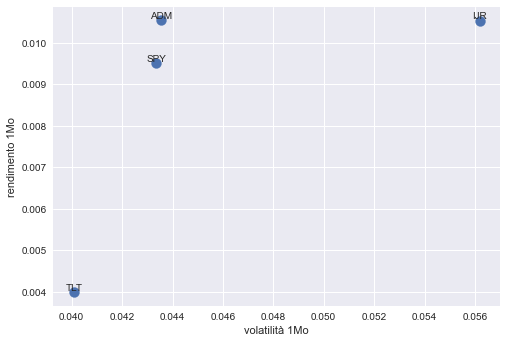

In [15]:
temp=pd.DataFrame([resultsm.mean(),resultsm.std()],index=["rendimento 1Mo","volatilità 1Mo"]).transpose()
temp.plot(kind="scatter",x="volatilità 1Mo",y="rendimento 1Mo",s=100)
for (xi, yi,zi) in zip(temp["volatilità 1Mo"],temp["rendimento 1Mo"],temp.index):
    plt.text(xi, yi, zi, va='bottom', ha='center')

In [16]:
anni=10
results=pd.DataFrame()
for i1 in range(len(df_az.index)-12*anni):
    i2=i1+12*anni
    t1=df_az.iloc[i1].dropna()
    t2=df_az.iloc[i2].dropna()
    #validi=[x for x in t1.index if x in t2.index]
    results.loc[df_az.index[i1], "SPY"] = ((t2["SPY"]/t1["SPY"])**(1/anni)-1)
    results.loc[df_az.index[i1], "IJR"] = ((t2["IJR"]/t1["IJR"])**(1/anni)-1)
    #results.loc[df_az.index[i1], "ADM"] = ((t2["ADM"]/t1["ADM"])**(1/anni)-1)*0.80 #!!!Taxes for strategy 20%!!!
    #results.loc[df_az.index[i1], "ADM"] = ((t2["ADM"]/t1["ADM"])**(1/anni)-1)*0.85 #!!!Taxes for strategy 15%!!!
    #results.loc[df_az.index[i1], "ADM"] = ((t2["ADM"]/t1["ADM"])**(1/anni)-1)*0.90 #!!!Taxes for strategy 10%!!!
    results.loc[df_az.index[i1], "ADM"] = ((t2["ADM"]/t1["ADM"])**(1/anni)-1)
    results.loc[df_az.index[i1], "TLT"] = ((t2["TLT"]/t1["TLT"])**(1/anni)-1)

In [17]:
results.describe()

,SPY,IJR,ADM,TLT
count,130.000000,130.000000,130.000000,130.000000
mean,0.106068,0.108169,0.122593,0.058264
std,0.031695,0.023612,0.022956,0.023520
min,0.063637,0.064141,0.077891,-0.001621
25%,0.075281,0.089381,0.106505,0.051011
50%,0.104845,0.105098,0.119713,0.066195
75%,0.134244,0.124985,0.130763,0.072612
max,0.165448,0.181870,0.183459,0.093868


In [18]:
tick_y=["SPY","IJR","ADM","TLT"]

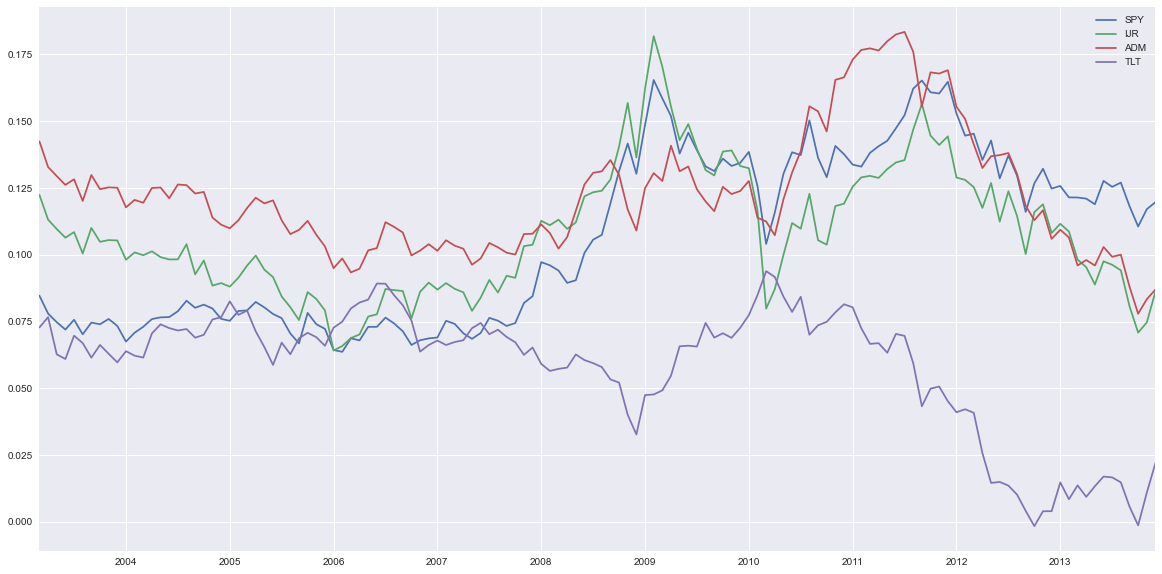

In [19]:
results[tick_y].plot(figsize=(20,10))

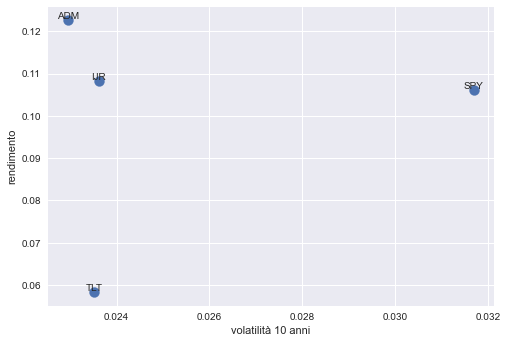

In [20]:
temp=pd.DataFrame([results.mean(),results.std()],index=["rendimento","volatilità 10 anni"]).transpose()
temp.plot(kind="scatter",x="volatilità 10 anni",y="rendimento",s=100)
for (xi, yi,zi) in zip(temp["volatilità 10 anni"],temp["rendimento"],temp.index):
    plt.text(xi, yi, zi, va='bottom', ha='center')

In [21]:


downside_returns = pd.DataFrame()
downside_returns[tick_y] = np.minimum(results[tick_y], 0.10)-0.10 # Seleziona solo i rendimenti sotto media
std_dev_downside = np.std(downside_returns)

mean= [np.mean(results["SPY"]),np.mean(results["IJR"]),np.mean(results["ADM"]),np.mean(results["TLT"]) ]


In [22]:
mean

[0.10606769263651238,
 0.10816917723504457,
 0.12259284674968321,
 0.05826373006658752]

In [23]:
downside_returns.describe()

,SPY,IJR,ADM,TLT
count,130.000000,130.000000,130.000000,130.000000
mean,-0.011685,-0.005619,-0.000755,-0.041736
std,0.013053,0.008815,0.002993,0.023520
min,-0.036363,-0.035859,-0.022109,-0.101621
25%,-0.024719,-0.010619,0.000000,-0.048989
50%,0.000000,0.000000,0.000000,-0.033805
75%,0.000000,0.000000,0.000000,-0.027388
max,0.000000,0.000000,0.000000,-0.006132


In [24]:
sortino = pd.DataFrame()
sortino["DownsideDev"] = std_dev_downside
sortino["Mean"] = mean

In [25]:
sortino

,DownsideDev,Mean
SPY,0.013003,0.106068
IJR,0.008781,0.108169
ADM,0.002981,0.122593
TLT,0.023429,0.058264


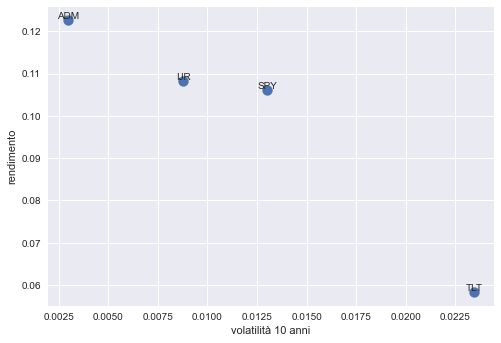

In [26]:
temp=pd.DataFrame([sortino["Mean"],sortino["DownsideDev"]],index=["rendimento","volatilità 10 anni"]).transpose()
temp.plot(kind="scatter",x="volatilità 10 anni",y="rendimento",s=100)
for (xi, yi,zi) in zip(temp["volatilità 10 anni"],temp["rendimento"],temp.index):
    plt.text(xi, yi, zi, va='bottom', ha='center')